<a href="https://colab.research.google.com/github/bitanb1999/customerReviews/blob/main/Customer_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Classifier

---

## Table of Contents 
  * [Part1: Building a Sentiment Classifier using Bag of Words (BOW)](###Part-1-Building-a-Sentiment-Classifier-using-Bag-of-Words-(BOW))
    * [1.1 Loading and Splitting data](###1.1-Loading-and-Splitting-the-data)
    * [1.2 Preprocessing](###1.2-Preprocessing)
    * [1.3 Tokenization](###1.3-Tokenization)
    * [1.4 Classification Model](###1.4-Classification-Model)
    * [1.5 Prediction and Accuracy](###1.5-Prediction-and-Accuracy)
    * [1.6 Confusion Matrix](###1.6-Confusion-Matrix)
    * [1.7 Viewing and decoding predictions](###1.7-Viewing-and-decoding-predictions)

In [ ]:
# Install the gensim & nltk libraries if not already installed
!pip install --upgrade pip
!pip install gensim
!pip install nltk

     |████████████████████████████████| 1.6MB 6.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [ ]:

import numpy as np
import pandas as pd
import gensim
from keras.preprocessing import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from sklearn.model_selection import train_test_split

import re
from bs4 import BeautifulSoup

import nltk

### Part 1 : Building a Sentiment Classifier using Bag of Words (BOW)

In this part, we will build a **Logistic Regression** model using the **Bag of Words (BOW)** approach. In BOW, every text or document is represented as the bag(multiset) of its words where the frequency of occurrence of each word is used as a feature for training a classifier. Check this [wikipedia link](https://en.wikipedia.org/wiki/Bag-of-words_model#:~:text=The%20bag%2Dof%2Dwords%20model,word%20order%20but%20keeping%20multiplicity.) for more information.



**1.1 Loading and Splitting data**

Load the data-set and split 

In [ ]:
# load and split data
df=pd.read_csv("/content/Data Analyst - Test Data - US.csv")
df.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor


In [ ]:
#helper function to view the table content details
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=52):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

**1.2 Preprocessing**

Clean the reviews by completing the following function. Follow the instructions as mentioned in the comments. Call this function to obtain a list of cleaned train and test reviews.

*Hint* - Use [**re.sub**](https://docs.python.org/3/library/re.html) to replace regular expressions or regex.

In [ ]:
tbl_report(df)

Table Shape (6448, 3)


In [ ]:
df.dropna(axis=0,how='any',inplace=True)

In [ ]:
# function to perform stemming

def stemming(text):
    
    # stems each word in the review to it's root word
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [ ]:
def preprocess_review(text):
    
    """
    Function
    --------
    preprocess_review

    Inputs
    ------
    text: the review which need to be pre-processed

    Returns
    -------
    clean_review: the pre-processed review obtained after performing the below instructions in the Notes

    Notes
    -----
    
    1. Remove html tags from the text
    2. Change all reviews to lowercase
    3. Remove special characters - remove everything that is not a letter or a space (use re.sub to replace regex pattern by single 
       space. The regex pattern for removal of special characters is '[^a-z\s]+')
    4. Remove extra(multiple) spaces (use re.sub to replace regex pattern by single space. The regex pattern for removal of multiple 
       spaces is '\s+')
    5. Perform stemming, which converts(stems) the word to its base form (for eg: running, runs to run)
    """
    
    
    clean_review = BeautifulSoup(text).get_text()
    clean_review = clean_review.lower()
    clean_review =re.sub(('[^a-z\s]+')," ",clean_review)
    clean_review =re.sub(('\s+')," ",clean_review)
    stemming_review = stemming(clean_review)
    #print(stemming_review)
    return stemming_review
    
    

In [ ]:
# Calling the preprocess_review function to obtain list of the cleaned reviews

X = [preprocess_review(review) for review in df['Review']]
print('data cleaned')


data cleaned


Let's check out an example of how a cleaned text looks like

In [ ]:
print(X[5])

veri nice and quiet and clean room we will return when back in the area read more read less


**1.3 Tokenization**

Encoded the cleaned reviews into integers which can be used by as features in our classification model. This is also called as **tokenization**. We will use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) method from the *sklearn* library with a maximum vocabulary size of 1000 and remove stopwords. *Stopwords* are commonly occuring words in English - like *and,i,for,us,the etc*

In [ ]:
tokenizer = CountVectorizer(max_features = 1000, stop_words = 'english')

Let's fit the tokenizer to our cleaned training set and store the train & test tokenized data to these variables respectively: **X_train_tokenized** and **X_test_tokenized**

In [ ]:
# tokenizing the words in X
tokenizer.fit(X)
X_train_tokenized = tokenizer.transform(X)



In [ ]:
# shape of the tokenized features for train data
print(X_train_tokenized.shape)

(1705, 1000)


*Removing the stop words is important as we have limited features to use for our model and these stop words if also considered might make us lose out on important keywords*


##### *The stemming should have been done after tokenizing the data as stemming in the pre processing phase already removes some stuff which could have been useful to understand the reviews.*


Printing out the top 10 most occuring words in the training set along with their frequency. Note that `tokenizer.vocabulary_` will only give you the index of the word in the vocab; not the count itself

In [ ]:


tokenized_sum = X_train_tokenized.sum(axis = 0)

count_list = []
for word,index in tokenizer.vocabulary_.items():
    count_list.append((word,tokenized_sum[0,index]))

sorted_countlist = sorted(count_list,key= lambda x: x[1],reverse= True)
print(sorted_countlist)

[('read', 3055), ('wa', 1873), ('room', 1268), ('hotel', 802), ('veri', 659), ('staff', 566), ('stay', 497), ('clean', 449), ('locat', 447), ('great', 433), ('nice', 385), ('thi', 372), ('park', 292), ('check', 280), ('bed', 261), ('time', 258), ('friendli', 241), ('good', 234), ('pool', 232), ('properti', 215), ('like', 214), ('night', 197), ('help', 192), ('walk', 188), ('servic', 185), ('day', 183), ('desk', 174), ('close', 162), ('onli', 160), ('need', 155), ('love', 150), ('disney', 147), ('area', 146), ('didn', 146), ('small', 145), ('just', 137), ('bathroom', 135), ('restaur', 134), ('comfort', 133), ('realli', 130), ('work', 122), ('breakfast', 117), ('did', 117), ('everyth', 117), ('place', 116), ('price', 111), ('lobbi', 110), ('new', 106), ('charg', 103), ('old', 102), ('look', 99), ('door', 99), ('floor', 97), ('shower', 97), ('resort', 96), ('lot', 96), ('definit', 95), ('got', 93), ('littl', 92), ('beauti', 92), ('excel', 90), ('use', 87), ('fee', 85), ('ask', 84), ('conv

**1.4 Classification model**

Use a *Logistic Regression* model for classification with the tokenized reviews as features. Fine-tune your model to find the best value of the hyper-parameter 'C' from the follwing values: *'{0.001,0.01,0.1,1,10,100}'*. Store the final model in the variable *'bow_model'*

In [ ]:
#arbitrarily making a y_train to fit in the logistic regression to show the probability efficacy of stating which are positive and which are negative reviews
y_train= np.random.random_sample((1705,))
y_train

array([0.29884172, 0.42130155, 0.89644152, ..., 0.26649476, 0.17355829,
       0.06258907])

In [ ]:
y_train=[1 if y>0.5 else 0 for y in y_train]

In [ ]:
#logistic regression to have a look at approximate positive and negative reviews
c=[0.001,0.01,0.1,1,10,100]
error=np.empty(6)
max=0
index=0
for i in range(6):
 logr=LogisticRegression(C=c[i])
 model=logr.fit(X_train_tokenized,y_train)
 predict_ontest=model.predict(X_train_tokenized)
 bow_model=logr.fit(X_train_tokenized,y_train)







/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


**1.5 Prediction and Accuracy**

Printing the accuracy of your model on both the train and test data-set. 

In [ ]:

print("training_set", accuracy_score(y_train,bow_model.predict(X_train_tokenized)))





training_set 0.9255131964809384


In [ ]:
print(c[index])

0.001


**1.6 Confusion Matrix**

Plot the confusion matrix (2x2 matrix of your actual vs predicted values) for both train and test data. Complete the function below which will help you with this. You can use the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from `sklearn` and the [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) from the `seaborn` library to help with this. They have already been imported at the start of this notebook

In [ ]:
# function to plot confusion matrix

def plot_confusion_matrix(model, validation_features, validation_labels):
     
    """
    Function
    --------
    plot_confusion_matrix

    Inputs
    ------
    model: the classification model
    validation_features: features/variables used in the model (X)
    validation_labels: response variable (good/bad sentiment) (y)

    Notes
    -----
    Calling this function should plot a confusion matrix. Use heatmap from the seaborn library
    """
    
    # Predict the values from the validation dataset
    y_pred = model.predict(validation_features)
    
    # Convert validation observations to one hot vectors
    y_true = [1 if y>0.5 else 0 for y in y_pred]
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(validation_labels,y_true)

    df_cm = pd.DataFrame(confusion_mtx, range(2),
                      range(2))
    sns.heatmap(df_cm, annot=True, annot_kws = {'size':15}, cmap = 'Blues',fmt = 'd',
                norm=LogNorm(df_cm.values.min(),df_cm.values.max()),
                cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4]},vmin=0.001, vmax=10000)
    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim(2,0)
    plt.show()
    

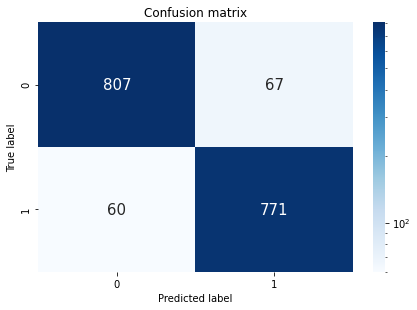

In [ ]:
# generating the confusion matrix plots for train data

plot_confusion_matrix(bow_model, X_train_tokenized, y_train)

**1.7 Viewing and decoding predictions**

Let's look at the test data for a few cases for the False Positives and False Negatives and see where we are going wrong with the Predictions

In [ ]:
y_pred = bow_model.predict(X_train_tokenized)
df_test = pd.DataFrame(list(zip(df['Review'], y_pred, y_train)), columns = ['X_train', 'y_pred', 'y_train'])

Creating 2 subset dataframes from **df_test** : **df_fp** for all False Positives and **df_fn** for all False Negatives 

In [ ]:
# False Positives
df_fp = df_test[(df_test['y_pred']==1) & (df_test['y_train']==0)]

# False Negatives
df_fn = df_test[(df_test['y_pred']==0) & (df_test['y_train']==1)]

Let's create a function to find out the words which contribute most to a particular review

In [ ]:
# This function takes in the input of the tokenized_review and returns the important words occuring in the review 
# (according to the tokenizer vocab) along with their frequency

def imp_words(tokenized_review):
    sum_words = X_train_tokenized.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in tokenizer.vocabulary_.items()]
    words_freq = dict(sorted(words_freq, key = lambda x: x[1], reverse=True))

    imp_words = []
    for x, val in enumerate(tokenized_review):
        if val >= 1:
            for word, index in tokenizer.vocabulary_.items():
                if index == x:
                    imp_words.append((word, words_freq[word]))
    
    return sorted(imp_words, key = lambda x: x[1], reverse=True)

Let's pick one of the False Positive cases from the `df_fp` dataframe.

In [ ]:
# to see an example of a FP review
df_fp['X_train'][64]

'Didnt accomodate me needing two queen beds for my family.\n  \n  Read more\n  Read less'

In [ ]:
# to see an example of a FN review
df_fn['X_train'][24]

'There was no complementary breakfast but it was close to everything and Disney Springs was remarkable\n  \n  Read more\n  Read less'

##Exploratory Data Analysis:

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
%matplotlib inline

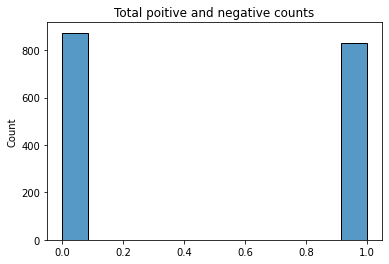

In [ ]:
plt.title("Total poitive and negative counts")
sns.histplot(y_train);

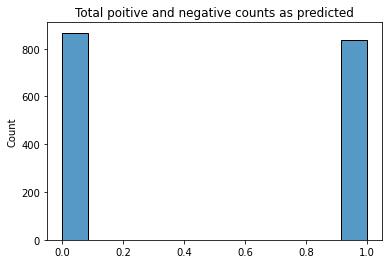

In [ ]:
plt.title("Total poitive and negative counts as predicted")
sns.histplot(y_pred);

In [ ]:
counts=df.groupby(by='Location')['Review'].count()
locations=counts.index

Text(0.5, 1.0, 'Highest number of reviews from')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38442 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38442 missing from current font.
  font.set_te

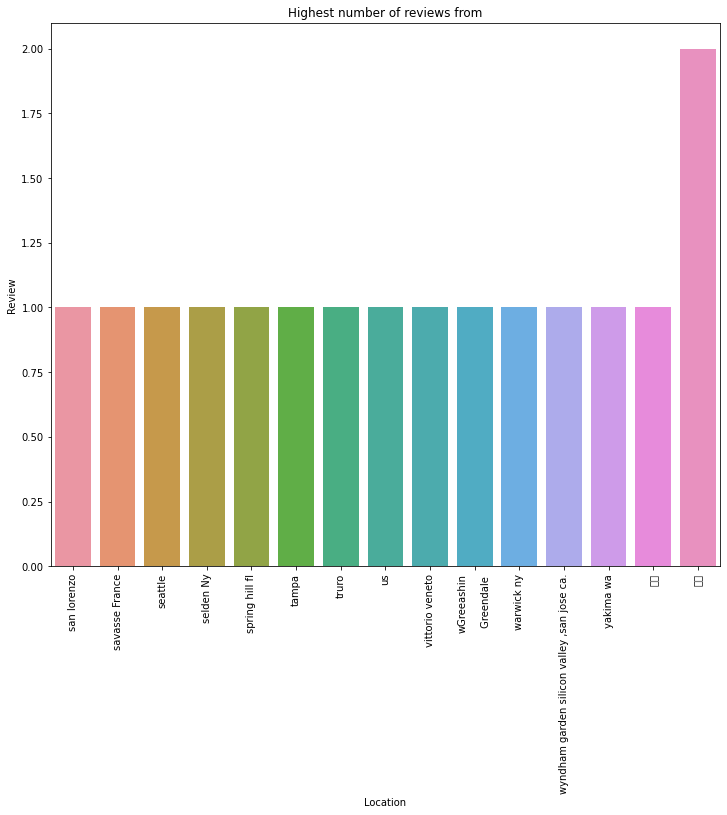

In [ ]:

fig,axes=plt.subplots(figsize=(12,10))
sns.barplot(x=locations,y=counts,ax=axes)
axes.set_xticklabels(labels=locations,rotation='90')
plt.title("Highest number of reviews from")

In [ ]:
len(locations)

1078

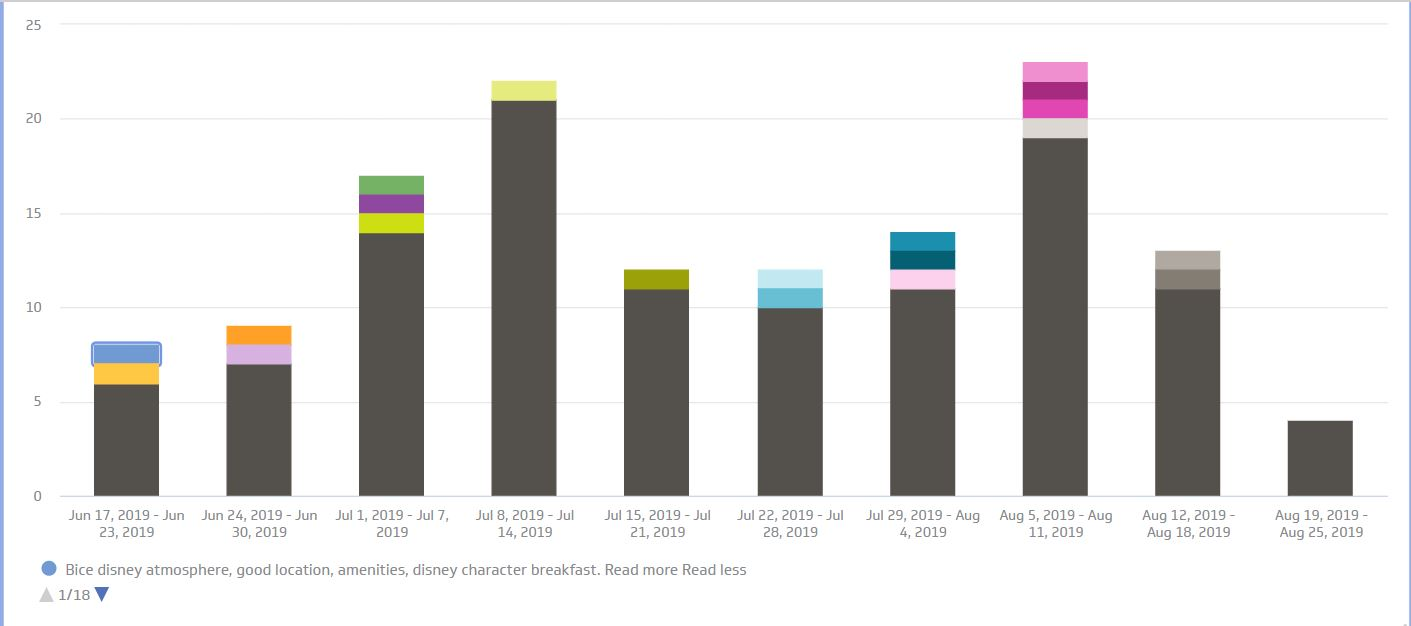

Number of reviews in different weeks


In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/highestreviews.JPG')
display(pil_img)
print("Number of reviews in different weeks")